SENTIMENT ANALYSIS USING LLMs.

In [1]:
# Libraries.
import pandas as pd
import matplotlib.pyplot as plt
import csv
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, Trainer, TrainingArguments, AdamW

C:\Users\asael\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [2]:
# Reading news corpus.
news = pd.read_csv('news_data.csv')

In [3]:
# Counting NaN values and filling with ''.
news['content'] = news['content'].fillna('')
news['text'] = news['title'] + ' ' + news['description'] + ' ' + news['content']

In [4]:
# Function for predict sentiment for each new in 2 targets: positive and negative.
def predict_sentiment(text):
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    probabilities = torch.softmax(logits, dim=1)
    sentiment = torch.argmax(probabilities, dim=1).item() + 1  # 1 to 5 rating.
    
    # Mapping each target.
    if sentiment in [1, 2]:
        return 'Negativo'
    else:
        return 'Positivo'

In [5]:
# Using LLM BERT Sentiment.
model_name = "nlptown/bert-base-multilingual-uncased-sentiment"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForSequenceClassification.from_pretrained(model_name)

C:\Users\asael\anaconda3\Lib\site-packages\transformers\utils\generic.py:260: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  torch.utils._pytree._register_pytree_node(


In [6]:
# Generating target for the corpus.
news['sentiment'] = news['text'].apply(predict_sentiment)

In [7]:
# Mapping targets in numbers.
label_mapping = {'Negativo': 0, 'Positivo': 1}
news['rating'] = news['sentiment'].map(label_mapping)

In [8]:
# Veryfing if we got it.
neutral_news = news.loc[news['sentiment'] == 'Positivo']
print(neutral_news[['text', 'sentiment']])

                                                  text sentiment
1     Bitcoin traders celebrate ‘good news’ as BTC ...  Positivo
2     Bitcoin price shows strength above its recent...  Positivo
5     Bitcoin ETFs need time to be ‘instrument of a...  Positivo
7     Bitcoin ‘could very well catch fire’ as next ...  Positivo
8     Bitcoin range recovery could boost UNI, SUI, ...  Positivo
..                                                 ...       ...
299  South Korea to discuss approval of spot Bitcoi...  Positivo
305   Bitcoin’s indecisiveness could drive investor...  Positivo
306   BTC price eyes sub-$65K hurdles as metric hin...  Positivo
313  What Do Bitcoin Miners Expect Next? What are m...  Positivo
315  V-shaped recoveries historically bullish for B...  Positivo

[129 rows x 2 columns]


In [9]:
# Results.
print(news[['text', 'sentiment']])

                                                  text sentiment
0     Bitcoin in ‘seasonal slog’ with slim chance o...  Negativo
1     Bitcoin traders celebrate ‘good news’ as BTC ...  Positivo
2     Bitcoin price shows strength above its recent...  Positivo
3     Bitcoin ETFs record combined $1.2B in outflow...  Negativo
4     Is crypto entering a bear market? — 5 Things ...  Negativo
..                                                 ...       ...
315  V-shaped recoveries historically bullish for B...  Positivo
316  New South Korean Regulator ‘Could Speed Up Bit...  Negativo
317  Bitcoin Price Analysis: Mt. Gox’s Latest Repay...  Negativo
318  Bitcoin Price Analysis: Current Bull Cycle Mir...  Negativo
319  Bitcoin Price Forecast: Will Michigan Consumer...  Negativo

[320 rows x 2 columns]


In [10]:
# Splitting the corpis in 80% train set and 20% for test set.
train_data, test_data = train_test_split(news, test_size=0.2, random_state=42)
# Splitting train set in 80% to get the validation set in 20%.
train_data, val_data = train_test_split(train_data, test_size=0.2, random_state=42)

print(len(train_data))
print(len(test_data))
print(len(val_data))

204
64
52


In [11]:
# Class.
class Dataset(torch.utils.data.Dataset):
    def __init__(self, texts, labels=None):
        self.encodings = tokenizer(texts, padding=True, truncation=True, max_length=512)
        self.labels = labels
    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        if self.labels:
            item["labels"] = torch.tensor(self.labels[idx])
        return item
    def __len__(self):
        return len(self.encodings["input_ids"])

In [12]:
# Datasets for each set.
train_dataset = Dataset(train_data['text'].tolist(), train_data['rating'].tolist())
val_dataset = Dataset(val_data['text'].tolist(), val_data['rating'].tolist())
test_dataset = Dataset(test_data['text'].tolist(), test_data['rating'].tolist())

In [13]:
# Function metrcis.
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="macro")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [14]:
# Configuration for training.
training_args = TrainingArguments(
    output_dir="output",
    evaluation_strategy="steps",
    eval_steps=100,
    num_train_epochs=3,
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    seed=0,
    load_best_model_at_end=True,
    fp16=False
)

In [15]:
# AdamW Optimizer.
optimizer = AdamW(model.parameters(), lr=2e-5)

# Configurar el `Trainer`
trainer = Trainer(
    model=model,
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    optimizers=(optimizer, None)
)

# Train the model.
trainer.train()

C:\Users\asael\anaconda3\Lib\site-packages\transformers\optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
C:\Users\asael\anaconda3\Lib\site-packages\accelerate\accelerator.py:444: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None)
  warnings.warn(
You're using a BertTokenizerFast tokenizer. Please note that with a fast tokenizer, using the `__call__` method is faster than using a method to encode the text followed by a call to the `pad` method to get a padded encoding.


Step,Training Loss,Validation Loss


TrainOutput(global_step=39, training_loss=0.49708082737066805, metrics={'train_runtime': 2530.0125, 'train_samples_per_second': 0.242, 'train_steps_per_second': 0.015, 'total_flos': 161028303187968.0, 'train_loss': 0.49708082737066805, 'epoch': 3.0})

In [16]:
# Evaluating model in test set.
predictions = trainer.predict(test_dataset)
print(predictions.metrics)

{'test_loss': 0.36943575739860535, 'test_accuracy': 0.859375, 'test_f1': 0.8512012399896667, 'test_runtime': 100.5271, 'test_samples_per_second': 0.637, 'test_steps_per_second': 0.04}


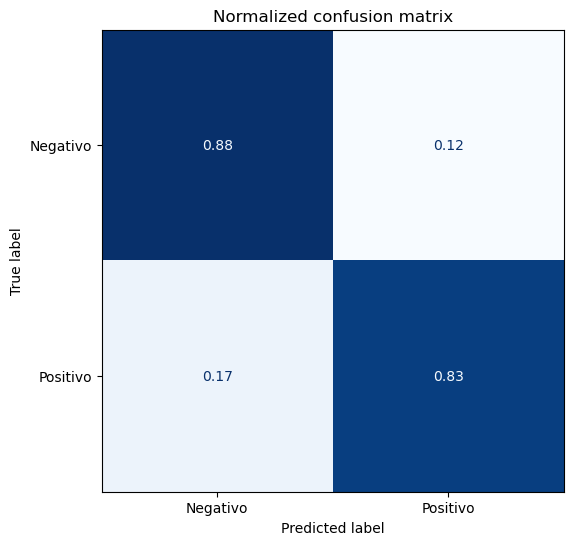

              precision    recall  f1-score   support

    Negativo       0.90      0.88      0.89        40
    Positivo       0.80      0.83      0.82        24

    accuracy                           0.86        64
   macro avg       0.85      0.85      0.85        64
weighted avg       0.86      0.86      0.86        64



In [17]:
# Confussion matrix to looke better the results.
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
import numpy as np

y_preds = np.argmax(predictions.predictions, axis=-1)
y_test = test_data['rating'].tolist()

# Graficar la matriz de confusión
def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

label_name = ['Negativo', 'Positivo']
plot_confusion_matrix(y_preds, y_test, label_name)

# Mostrar reporte de clasificación
print(classification_report(y_test, y_preds, target_names=label_name))